In [1]:
import time
import dask
import numpy as np

In [2]:
import dask.array as da
from dask import delayed

# RIME

$$\textbf{V}_{ij}(t,\nu) = \textbf{G}_{i}(\sum_s \textbf{E}_{i s} \textbf{K}_{i s}\textbf{B}_{s}\textbf{K}_{js}^{H}\textbf{E}_{js}^{H})\textbf{G}_{j}^{H}$$

where each term is a 2x2 matrix that is a function of time and frequency. $s, t, \nu$ stand for sources, time and frequency respectively. $i$ and $j$ are antenna indices.

In [3]:
def RIME(B, K, E, G, autos=False, dask=False):
    """
    Calculate the RIME for a given brightness matrix, 
    phase delay matrix, direction-dependent and 
    direction-independent effects. 
    
    Parameters:
    -----------
    B: np.array (2,2,n_time,n_freq,n_src)
        The brightness tensor.
    K: np.array (n_time,n_freq,n_ant,n_src)
        The phase delay tensor.
    E: np.array (2,2,n_time,n_freq,n_ant,n_src)
        The direction dependent effects tensor.
    G: np.array (2,2,n_time,n_freq,n_ant)
        The direction independent effects.
    autos: boolean
        Toggle autocorrelations on and off.
        
    Returns:
    --------
    V: np.array (2,2,n_time,n_freq,n_bl)
        The visibilies tensor. n_bl = n_ant*(n_ant-1)/2
    """
    
    if dask:
        einsum = da.einsum
        conj = da.conj
    else:
        einsum = np.einsum
        conj = np.conjugate
    
    a1, a2 = np.triu_indices(G.shape[-1], 0 if autos else 1)
    
#     Source coherency tensor
    X = B[:,:,:,:,None,:]*K[None,None,:,:,a1,:]*conj(K[None,None,:,:,a2,:])
    
#     Apparent source coherency
    A = einsum(('iAtfbs,ABtfbs,jBtfbs->ijtfbs'), E[...,a1,:], X, 
                conj(E[...,a2,:]), optimize='optimal')
    
#     Visibilities
    V = einsum('iAtfb,ABtfbs,jBtfb->ijtfb', G[...,a1], A, 
               conj(G[...,a2]), optimize='optimal')
    
    return V

In [4]:
def gen_random(shape, name, chunks=None, fulldask=False):
    
    if fulldask and chunks:
#         This is a delayed computation using Dask's numpy-like api
        A = da.random.standard_normal(shape, chunks)*da.exp(2.j*da.random.random(shape, chunks))
    else:
#         This is a traditional numpy calculation 
        A = np.random.randn(*shape)*np.exp(2.j*np.pi*np.random.random(shape))
        if chunks:
#             This is a numpy array being saved to disk with Dask
            da.to_zarr(da.from_array(A, chunks=chunks), str(name).upper()+'.zarr', overwrite=True, compute=True)
            A = da.from_zarr(str(name).upper()+'.zarr')
        
    return A

In [5]:
def gen_vars(prob_size, chunks, fulldask):
    
    n_time, n_freq, n_ant, n_src = prob_size
    if chunks=='auto':
        b_chunks, k_chunks, e_chunks, g_chunks = 'auto'
    elif chunks:
        b_chunks = list(chunks[:4])+list(chunks[-1:])
        k_chunks = chunks[2:]
        e_chunks = chunks
        g_chunks = chunks[:-1]
    else:
        b_chunks, k_chunks, e_chunks, g_chunks = [None, None, None, None]
    B = gen_random((2,2,n_time,n_freq,n_src), 'B', b_chunks, fulldask)
    K = gen_random((n_time,n_freq,n_ant,n_src), 'K', k_chunks, fulldask)
    E = gen_random((2,2,n_time,n_freq,n_ant,n_src), 'E', e_chunks, fulldask)
    G = gen_random((2,2,n_time,n_freq,n_ant), 'G', g_chunks, fulldask)
    
    return B, K, E, G

# Set problem size

In [6]:
n_time, n_freq, n_ant, n_src = [10, 512, 16, 10]
prob_size = [n_time, n_freq, n_ant, n_src]
n_bl = n_ant*(n_ant-1)//2

# Pure NumPy

In [7]:
chunks = None
fulldask = False

### Create variables

In [8]:
s0 = time.time()
B, K, E, G = gen_vars(prob_size, chunks, fulldask)
var_time = time.time() - s0

### Calculate visibilities

In [9]:
s = time.time()
V = RIME(B, K, E ,G)
vis_time = time.time() - s
print('Visibility calculation : {} s\nTotal calculation : {} s'.format(vis_time, vis_time+var_time))

Visibility calculation : 3.4388980865478516 s
Total calculation : 4.410748243331909 s


# Check on variable sizes

In [10]:
whos

Variable     Type        Data/Info
----------------------------------
B            ndarray     2x2x10x512x10: 204800 elems, type `complex128`, 3276800 bytes (3.125 Mb)
E            ndarray     2x2x10x512x16x10: 3276800 elems, type `complex128`, 52428800 bytes (50.0 Mb)
G            ndarray     2x2x10x512x16: 327680 elems, type `complex128`, 5242880 bytes (5.0 Mb)
K            ndarray     10x512x16x10: 819200 elems, type `complex128`, 13107200 bytes (12.5 Mb)
RIME         function    <function RIME at 0x7f4548135bf8>
V            ndarray     2x2x10x512x120: 2457600 elems, type `complex128`, 39321600 bytes (37.5 Mb)
chunks       NoneType    None
da           module      <module 'dask.array' from<...>/dask/array/__init__.py'>
dask         module      <module 'dask' from '/opt<...>ckages/dask/__init__.py'>
delayed      curry       <function delayed at 0x7f453adc4378>
fulldask     bool        False
gen_random   function    <function gen_random at 0x7f4548135ae8>
gen_vars     function    <fu

# Set problem size

In [11]:
n_time, n_freq, n_ant, n_src = [10, 512, 16, 10]
n_bl = n_ant*(n_ant-1)//2

# Dask from disk

In [12]:
chunks = [2,2,n_time,n_freq,n_ant,n_src]
fulldask = False

### Create variables

In [13]:
s0 = time.time()
B, K, E, G = gen_vars(prob_size, chunks, fulldask)
var_time = time.time() - s0

### Calculate visibilities

In [31]:
s = time.time()
Vs = []
for i in range(n_freq):
    V = delayed(RIME)(B[:,:,:,i,None], K[:,i,None], E[:,:,:,i,None], G[:,:,:,i,None])
    Vs.append(V)
V = [da.from_delayed(Vs[i], (2,2,n_time,1,n_bl), dtype=np.complex64) for i in range(n_freq)]
V = da.concatenate(V, axis=3).rechunk({3: 2})
var_time += time.time() - s

In [32]:
V

,Array,Chunk
Bytes,19.66 MB,76.80 kB
Shape,"(2, 2, 10, 512, 120)","(2, 2, 10, 2, 120)"
Count,5908 Tasks,256 Chunks
Type,complex64,numpy.ndarray


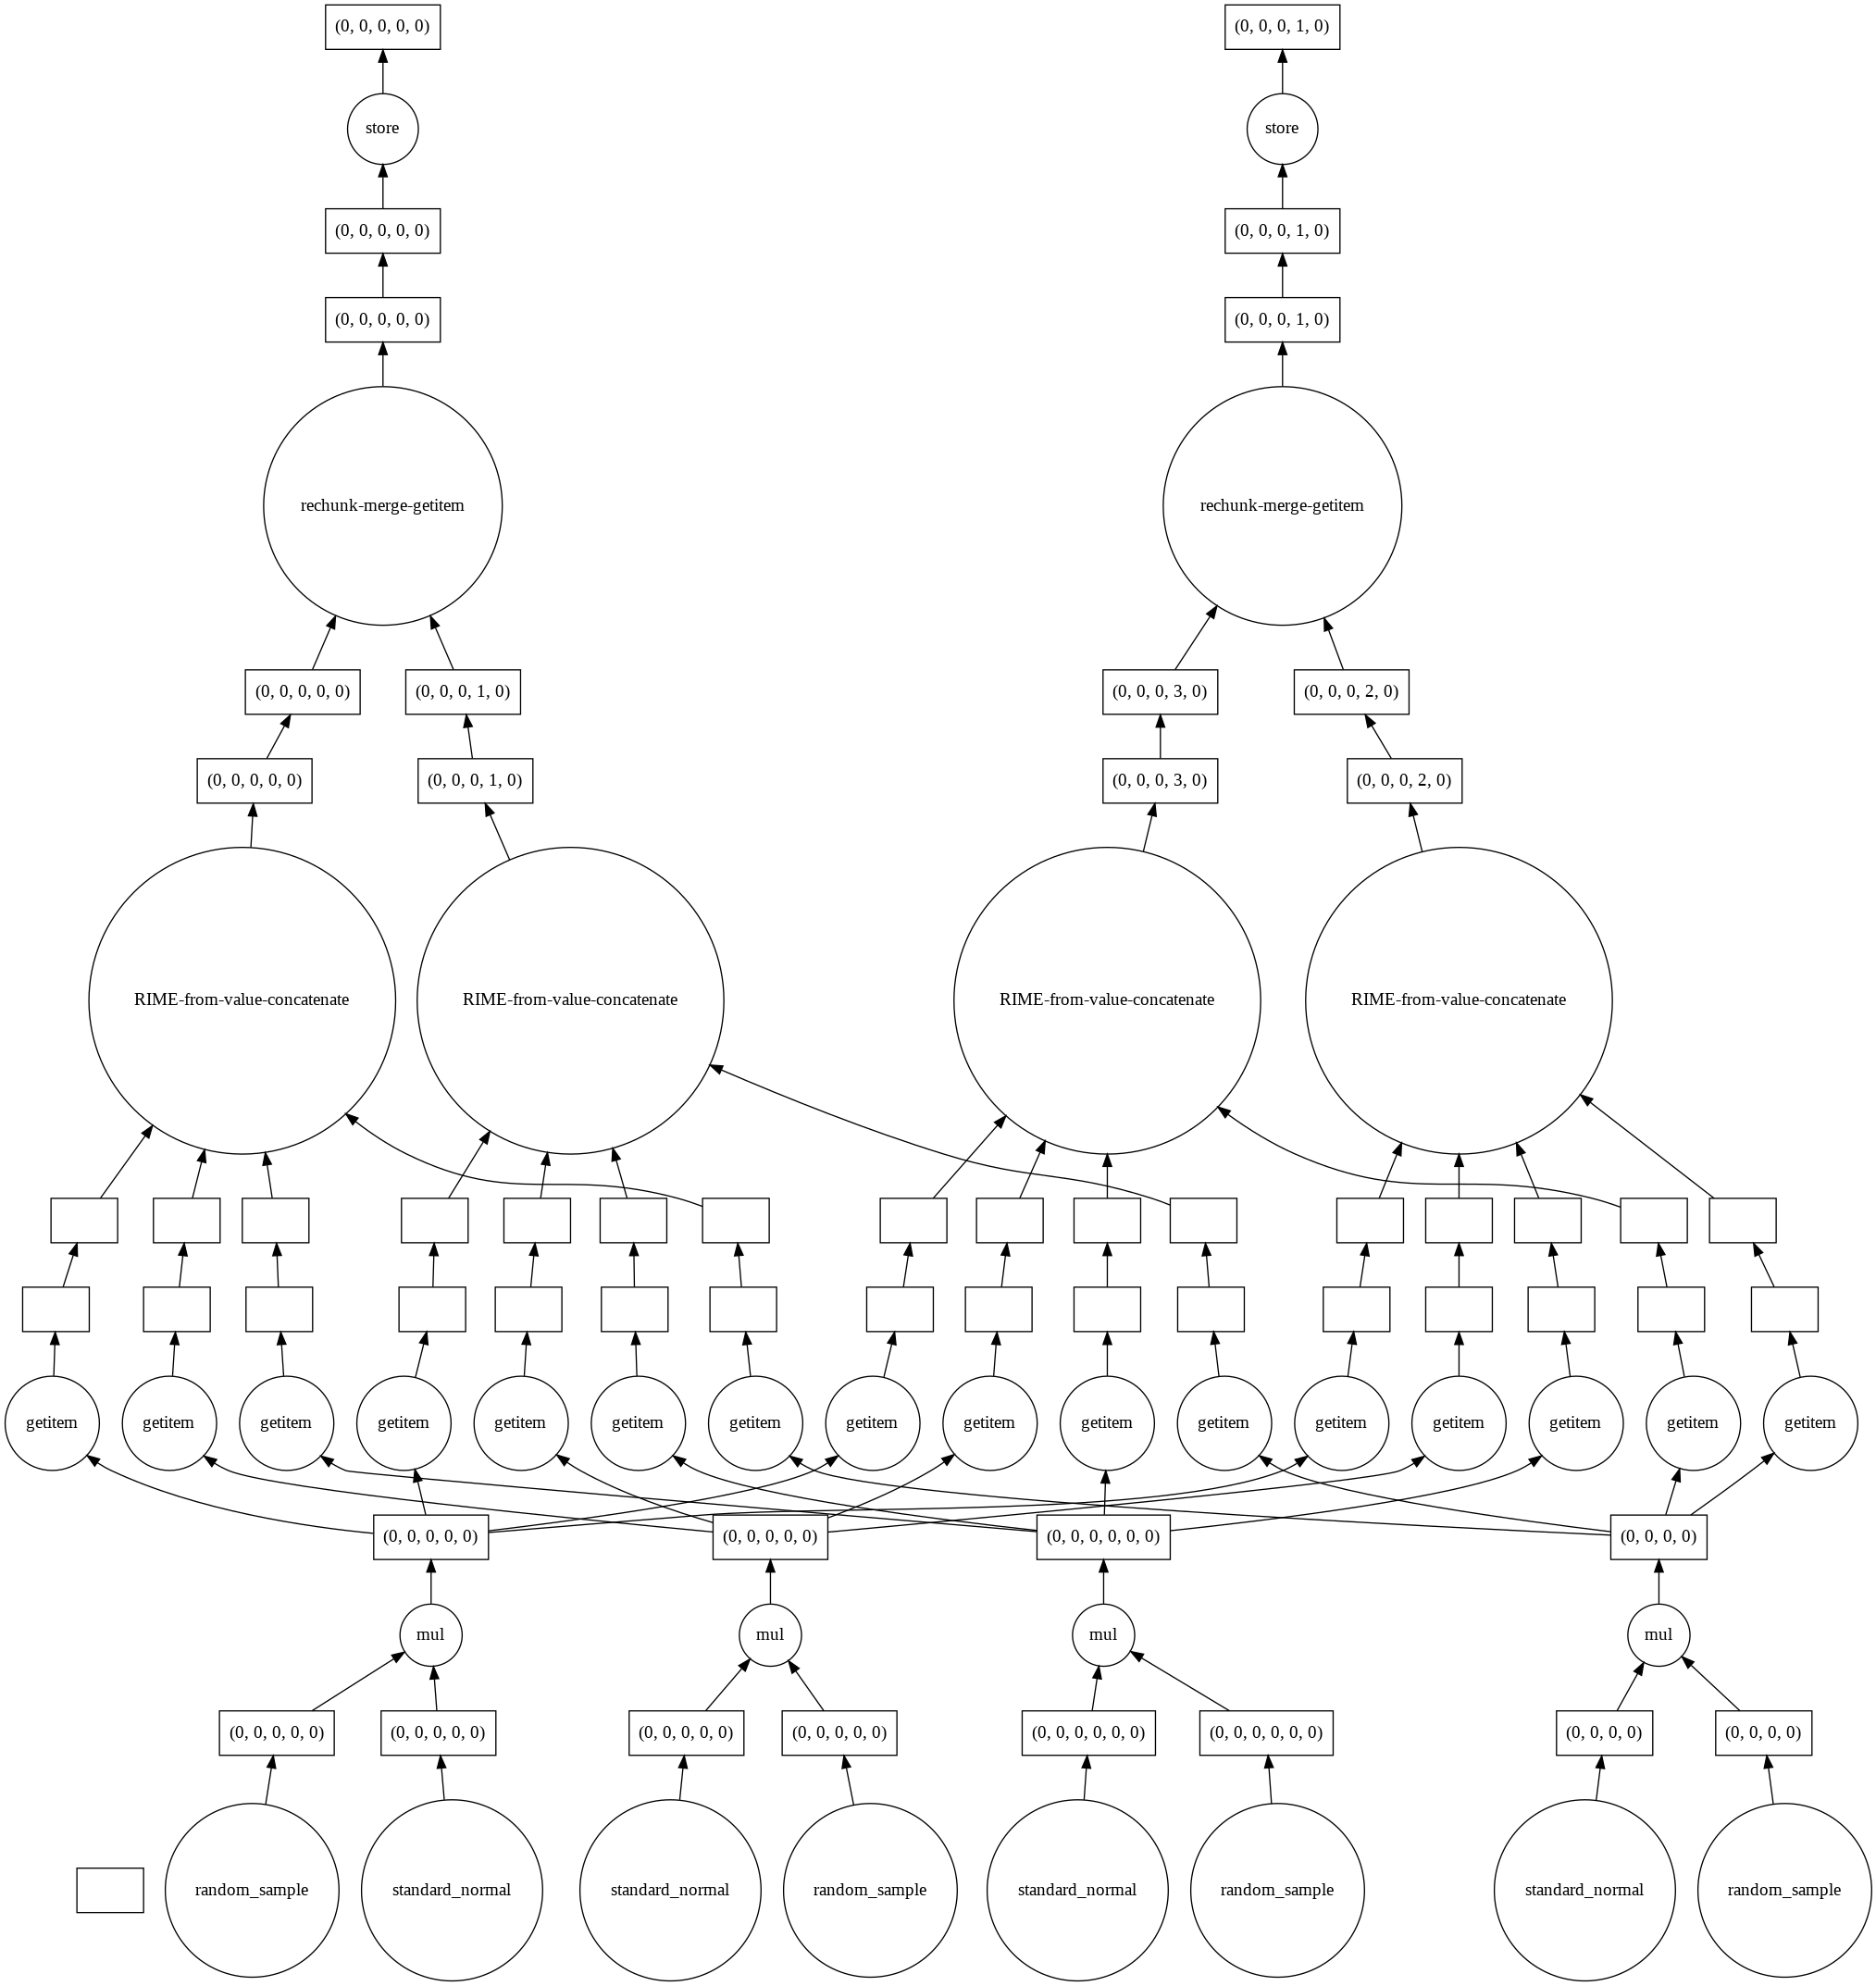

In [33]:
da.to_zarr(V[:,:,:,:4,:], 'vis_from_disk.zarr', overwrite=True, compute=False).visualize()

In [34]:
s = time.time()
da.to_zarr(V, 'vis_from_disk.zarr', overwrite=True, compute=True)
vis_time = time.time() - s
print('Visibility calculation : {} s\nTotal calculation : {} s'.format(vis_time, vis_time+var_time))

Visibility calculation : 4.610034227371216 s
Total calculation : 6.471296548843384 s


# Set problem size

In [35]:
n_time, n_freq, n_ant, n_src = [10, 512, 16, 10]
n_bl = n_ant*(n_ant-1)//2

# Pure Dask 

In [22]:
chunks = [2,2,n_time,n_freq,n_ant,n_src]
fulldask = True

### Create variables

In [23]:
s0 = time.time()
B, K, E, G = gen_vars(prob_size, chunks, fulldask)
var_time = time.time() - s0

### Calculate visibilities

In [24]:
s = time.time()
V = RIME(B, K, E, G, dask=True)
var_time += time.time() - s

In [25]:
V

dask.array<sum-aggregate, shape=(2, 2, 10, 512, 120), dtype=complex128, chunksize=(2, 2, 10, 512, 120)>

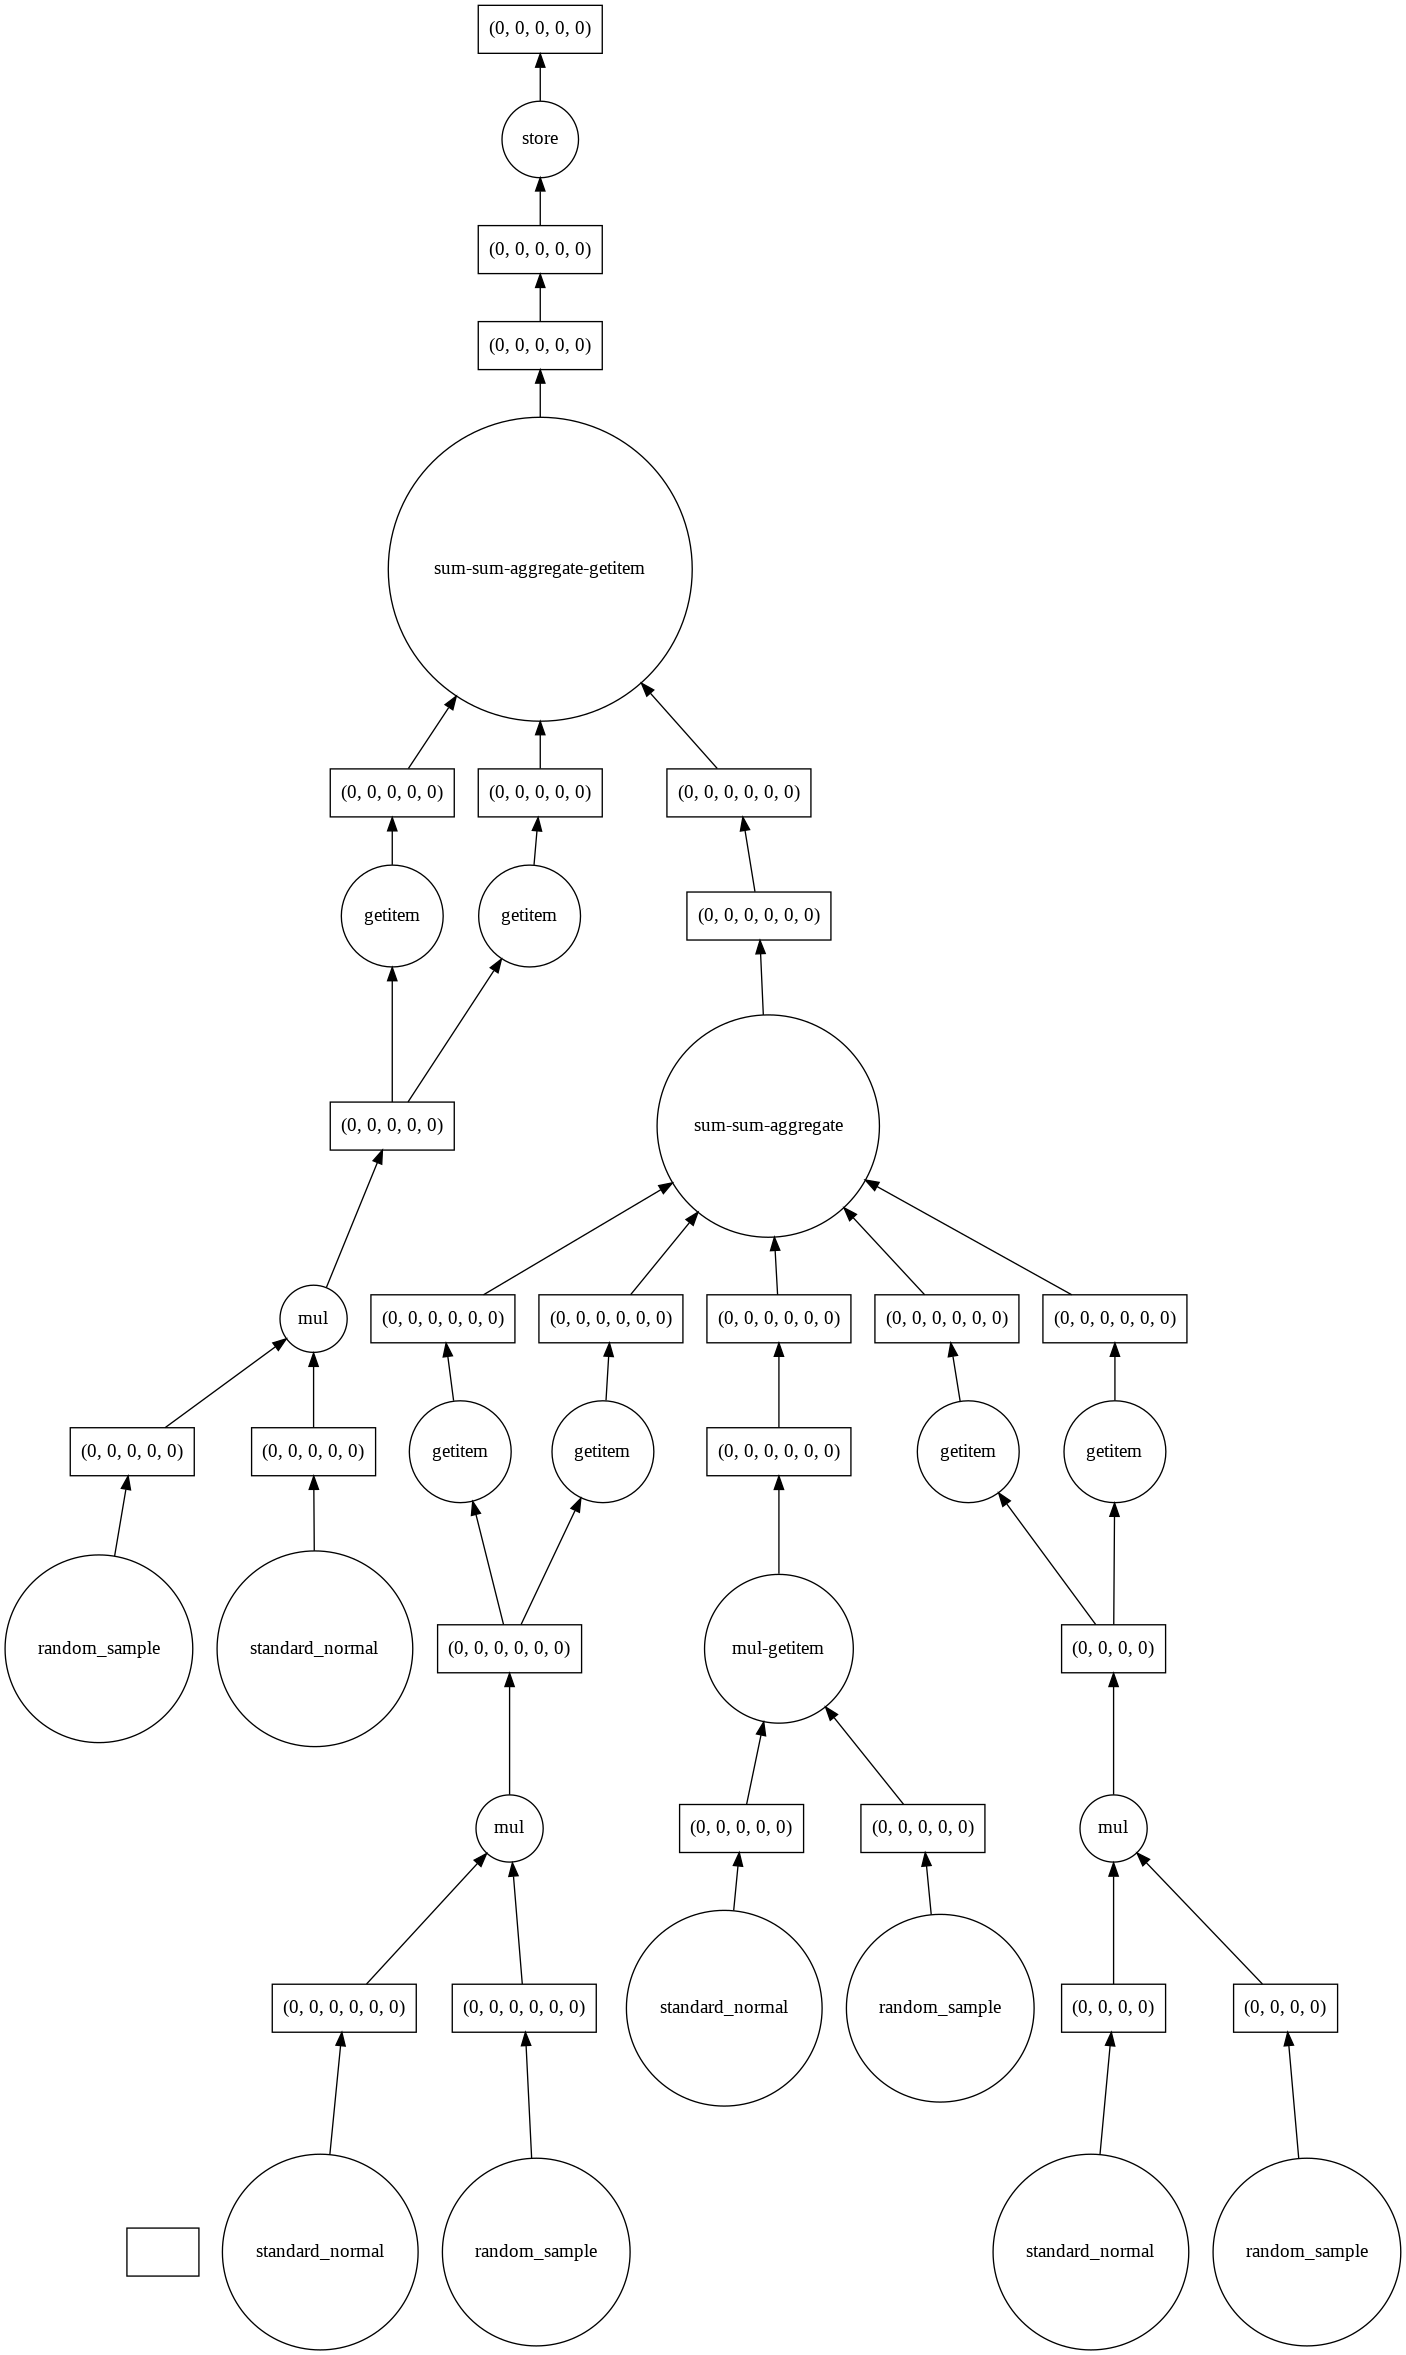

In [26]:
da.to_zarr(V[:,:,:,:4,:], 'pure_dask_vis.zarr', overwrite=True, compute=False).visualize()

In [29]:
s = time.time()
da.to_zarr(V, 'pure_dask_vis.zarr', overwrite=True)
vis_time = time.time() - s
print('Visibility calculation : {} s\nTotal calculation : {} s'.format(vis_time, vis_time+var_time))

Visibility calculation : 6.7889721393585205 s
Total calculation : 6.8431737422943115 s
